<a href="https://colab.research.google.com/github/carversh/DL_sc/blob/main/simulate_data_loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

In [ ]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.4 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# Set the current working directory
os.chdir('/content/drive/MyDrive/AM231_project')

In [ ]:
!tensorboard --logdir=data/logs

2023-05-23 22:13:49.282519: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 22:13:50.171039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server)
/usr/local/lib/python3.10/dist-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.

In [ ]:
torch.__version__

'2.0.0+cu118'

In [ ]:

class xDzDataset(torch.utils.data.Dataset):
    def __init__(self, params, D=None):

        # these four must be set
        self.num_cells = params["num_cells"]
        self.num_genes = params["num_genes"]
        self.num_modules = params["num_modules"]
        self.s = params["s"] # num non-zero entries (sparsity s-sparse code)
        self.device = params["device"]
        self.manual_seed = params["manual_seed"]

        ######
        try:
          print(self.code_dist)
        except:
           self.code_dist = "uniform"
           params["c_min"] = 1
           params["c_max"] = 2

        if self.code_dist == "uniform":
            self.c_min = params["c_min"]
            self.c_max = params["c_max"]
        else:
            self.z_mean = params["z_mean"]
            self.z_std = params["z_std"]

        self.num_distinct_supp_sets = 1


        # generate code
        if self.code_dist == "uniform":
            self.z = self.generate_sparse_samples_uniform(
                self.num_cells,
                self.num_modules,
                self.s,
                self.c_min,
                self.c_max,
                self.num_distinct_supp_sets,
                device=self.device,
                seed=self.manual_seed,
            )
        elif self.code_dist == "subgaussian":
            self.z = self.generate_sparse_samples_subgaussian(
                self.num_cells,
                self.num_modules,
                self.s,
                self.z_mean,
                self.z_std,
                self.num_distinct_supp_sets,
                device=self.device,
                seed=self.manual_seed,
            )
        else:
            print("Code distribution is not implemented!")
            raise NotImplementedError

        # create filters
        if D is None:
            D = (1 / np.sqrt(self.num_genes)) * torch.randn(
                (self.num_genes, self.num_modules), device=self.device
            )
            D = F.normalize(D, p=2, dim=0)
            D *= 1
        self.D = D
        # generate data
        self.x = torch.matmul(self.D, self.z)

    def generate_sparse_samples_uniform(
        self, n, p, s, c_min=1, c_max=2, num_distinct_supp_sets=1, device="cpu", seed=None
    ):

        samples = torch.zeros((n, p, 1), device=device)
        torch.manual_seed(seed)
        np.random.seed(seed)
        for j in range(num_distinct_supp_sets):
            example_set_size = int(n / num_distinct_supp_sets)
            for i in range(example_set_size):
                supp_set_size = int(p / num_distinct_supp_sets)
                ind = np.random.choice(supp_set_size, s, replace=False)
                ind = ind + j * supp_set_size
                i = i + j * example_set_size
                # [1, 2]
                samples[i][ind, 0] = (
                    torch.rand(s, device=device) * (c_max - c_min) + c_min
                ) * ((torch.rand(1, device=device) > 0.5) * 2 - 1)

        return samples

    def generate_sparse_samples_subgaussian(
        self, n, p, s, z_mean, z_std, num_distinct_supp_sets=1, device="cpu", seed=None
    ):
        samples = torch.zeros((n, p, 1), device=device)
        torch.manual_seed(seed)
        np.random.seed(seed)
        for j in range(num_distinct_supp_sets):
            example_set_size = int(n / num_distinct_supp_sets)
            for i in range(example_set_size):
                supp_set_size = int(p / num_distinct_supp_sets)
                ind = np.random.choice(supp_set_size, s, replace=False)
                ind = ind + j * supp_set_size
                i = i + j * example_set_size
                samples[i][ind, 0] = (
                    torch.randn(s, device=device) * z_std + z_mean
                ) * ((torch.rand(1, device=device) > 0.5) * 2 - 1)

        return samples

    def __len__(self):
        return self.num_cells

    def __getitem__(self, idx):
        with torch.no_grad():
            return self.x[idx], self.z[idx]

In [ ]:
params = {
    "num_cells": 5000,
    "num_genes": 200,
    "num_modules": 10,
    "s": 2,
    "device": "cuda:0" if torch.cuda.is_available() else "cpu",
    "manual_seed": 123
}

In [ ]:
data = xDzDataset(params)

In [ ]:
data.x.shape

torch.Size([5000, 200, 1])

In [ ]:
data.D.shape

torch.Size([200, 10])

In [ ]:
data.z.shape

torch.Size([5000, 10, 1])

In [ ]:
np.save(data.D.numpy(), "true_dictionary.npy")

array([[ 0.01912871, -0.00429055, -0.10832225, ...,  0.07957787,
        -0.07409303, -0.01984345],
       [ 0.07977472,  0.07298002, -0.12599306, ..., -0.00633635,
        -0.1434675 ,  0.07299698],
       [-0.05934841,  0.0328825 , -0.04378047, ..., -0.02928104,
         0.04546118,  0.03556442],
       ...,
       [-0.04479703,  0.08965091,  0.01823806, ...,  0.00246763,
        -0.04199019, -0.08021071],
       [ 0.00640252,  0.04929949, -0.00754681, ...,  0.0602994 ,
        -0.13942294,  0.03859779],
       [ 0.02598684,  0.03592507, -0.09275985, ...,  0.00992862,
        -0.04404978,  0.01251978]], dtype=float32)

In [ ]:

np.save(np.squeeze(data.z, axis=2).numpy(), "true_code.npy")

torch.Size([5000, 10])

In [ ]:
np.save(np.squeeze(data.x, axis=2).numpy(),"true_data_X.npy")

torch.Size([5000, 200])

In [ ]:
import os
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# Set the current working directory
os.chdir('/content/drive/MyDrive/AM231_project')

Mounted at /content/drive


In [ ]:
output_code = np.squeeze(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/sim_sim_code_recovery_no_train_lambda_0.1_laplacian_False_epochs_200_2023_05_16_00_15_56/code_no_learning.npy"), axis=2)
input_code = np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/sim_sim_code_recovery_no_train_lambda_0.1_laplacian_False_epochs_200_2023_05_16_00_15_56/true_code.npy")

FileNotFoundError: ignored

In [ ]:
print(output_code.shape)
print(input_code.shape)
import matplotlib.pyplot as plt

(20, 10)
(20, 10)


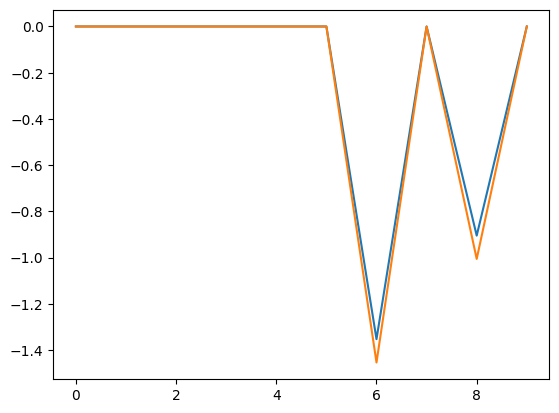

In [ ]:
plt.plot(output_code[4,:])
plt.plot(input_code[4,:])
plt.show()

In [ ]:
from scipy.optimize import linear_sum_assignment as lsa
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.pyplot import figure
figure(figsize=(2, 1.5), dpi=80)
folder_name = "sim_initialize_true_dictionary_lambda_0.1_laplacian_False_epochs_200_2023_05_16_19_01_55" # pytorch (simulated + initialized with true dictionary)
#folder_name = "sim_initialize_rand_dictionary_from_data_lambda_0.1_laplacian_False_epochs_200_2023_05_16_20_16_33" # pytorch (simulated + initialized with random dictionary from X)
output_dict = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{folder_name}/true_dictionary.npy")
input_dict = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{folder_name}/dictionary_sim_final_unrolled.npy")

<Figure size 160x120 with 0 Axes>

In [ ]:
# computes similarity between dictionaries
# inputted dictionaries must be genes by modules
def dictionary_distance(d, dhat, permute=True, eps=1e-6, dictionary=True):

    assert d.shape == dhat.shape # make suer dictionaries are the same shape
    m, p = d.shape # m = genes, p = atoms

    # d = d.clone()
    # dhat = dhat.clone()

    d = d
    dhat = dhat

    d /= torch.norm(d, keepdim=True, dim=0) # divide by norm so that the l2 norm sums to 1 (dividing every entry of the column by the norm)
    dhat /= torch.norm(dhat, keepdim=True, dim=0)

    d = torch.nan_to_num(d) # set NA to 0
    dhat = torch.nan_to_num(dhat)

    cost = torch.zeros(p, p) # make atom by atom matrix to store error in similarity

    for i in range(p):
        for j in range(p):
            a = 1 - torch.dot(d[:, i], dhat[:, j]).pow(2)
            cost[i, j] = torch.sqrt(a + eps)
    p = lsa(cost) if permute else (np.arange(p), np.arange(p))

    reordered_dhat = dhat[:,list(indices[1])]
    for sample in [4, 19,7,1]:
      plt.gcf().set_size_inches(5, 4)
      plt.plot(d[sample,:], "--",label="Reference", linewidth=3)
      plt.plot(reordered_dhat[sample,:], label="Pytorch")
      plt.xlabel("Atoms")
      if dictionary:
        plt.title(f"Dictionary Across Sample {sample}")
      else:
        plt.title(f"Code Across Sample {sample}")
      plt.legend()
      plt.show()
      plt.clf()

    return cost[p], cost[p].median(), cost[p].max(), p

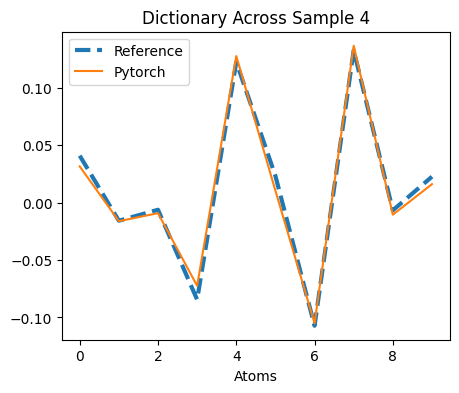

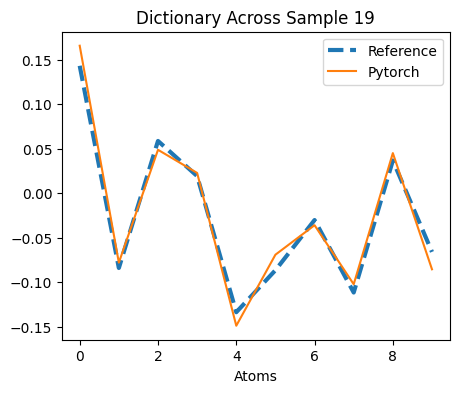

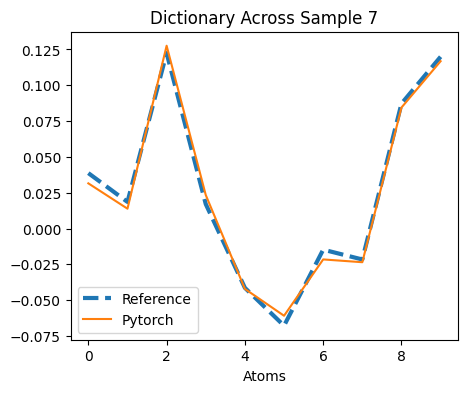

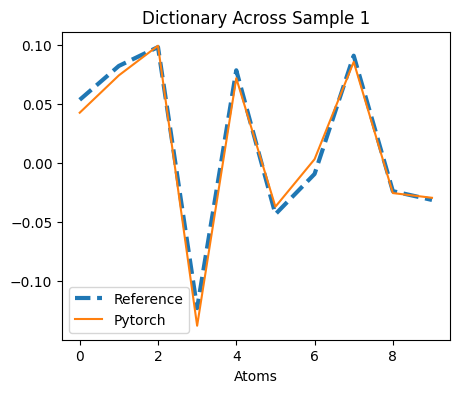

cost tensor([0.1337, 0.0949, 0.1076, 0.1991, 0.1043, 0.1349, 0.1672, 0.0950, 0.1173,
        0.1541])
median tensor(0.1173)
max tensor(0.1991)


<Figure size 640x480 with 0 Axes>

In [ ]:
(cost, median, max, indices ) = dictionary_distance( torch.tensor(input_dict),torch.tensor(output_dict) )
print("cost", cost)
print("median", median)
print("max", max)

In [ ]:
input_code = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{folder_name}/true_code.npy")
output_code = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{folder_name}/code_sim_final_unrolled.npy")

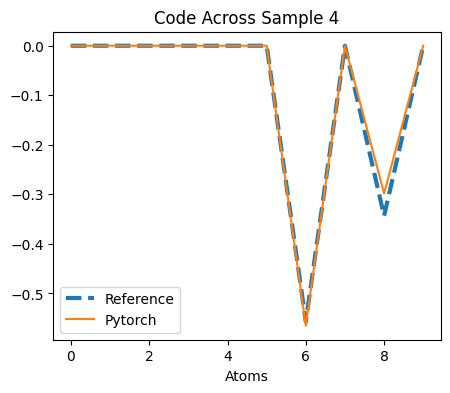

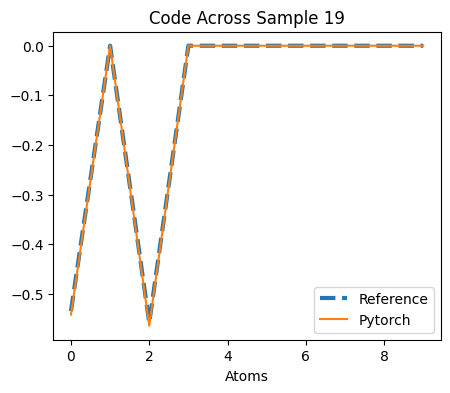

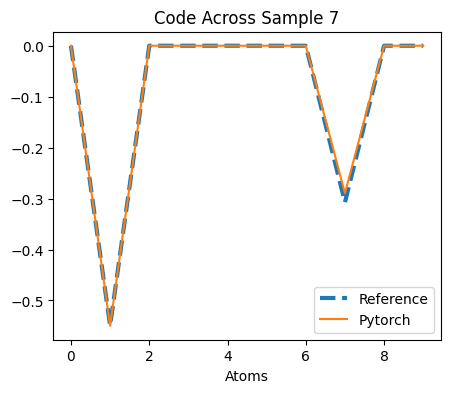

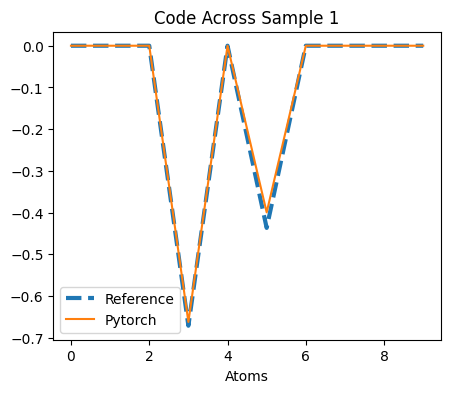

cost tensor([0.0878, 0.0077, 0.0194, 0.0122, 0.0550, 0.0505, 0.0193, 0.0267, 0.0530,
        0.0361])
median tensor(0.0267)
max tensor(0.0878)


<Figure size 640x480 with 0 Axes>

In [ ]:

(cost, median, max, indices ) = dictionary_distance( torch.tensor(input_code),torch.tensor(output_code),dictionary=False)
print("cost", cost)
print("median", median)
print("max", max)

In [ ]:
from scipy.optimize import linear_sum_assignment as lsa
import numpy as np
import matplotlib.pyplot as plt
import torch

folder_name = "guide_pooled_batch_512_initial_dict_data_lambda_0.1_laplacian_False_epochs_200_2023_05_16_21_00_12"
input_dict = np.load("/content/drive/MyDrive/AM231_project/data/SPAMS_output/SPAMS_dictionary_KD_guide_pooled.npy")
output_dict = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{folder_name}/dictionary_guide_pooled_final_unrolled.npy")

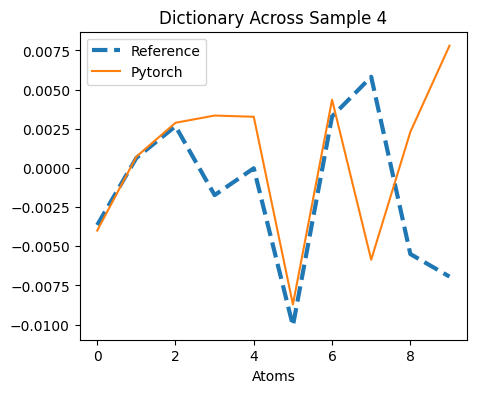

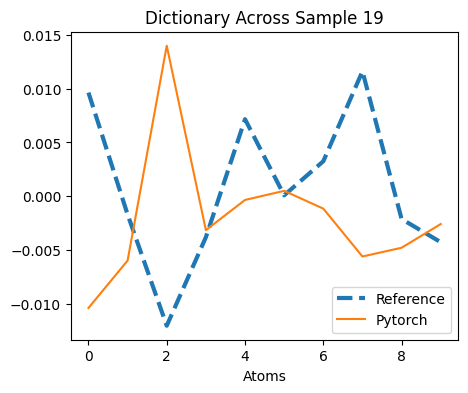

cost tensor([0.8061, 0.8914, 0.6354, 0.8205, 0.9761, 0.8708, 0.4902, 0.6961, 0.7926,
        0.7361])
median tensor(0.7926)
max tensor(0.9761)


<Figure size 640x480 with 0 Axes>

In [ ]:
(cost, median, max, indices ) = dictionary_distance( torch.tensor(input_dict, dtype=torch.float32),torch.tensor(output_dict, dtype=torch.float32) )
print("cost", cost)
print("median", median)
print("max", max)

In [ ]:
input_code = np.load("/content/drive/MyDrive/AM231_project/data/SPAMS_output/SPAMS_code_KD_guide_pooled.npy").T
output_code = np.load(f"/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/{folder_name}/code_guide_pooled_final_unrolled.npy")

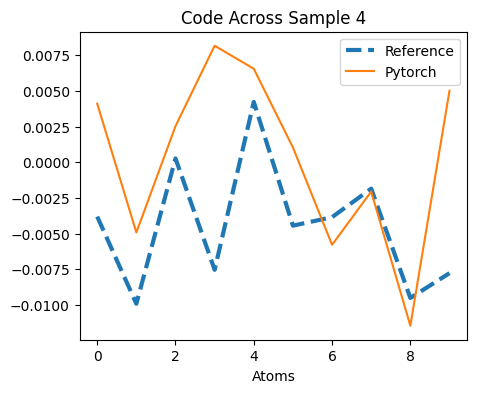

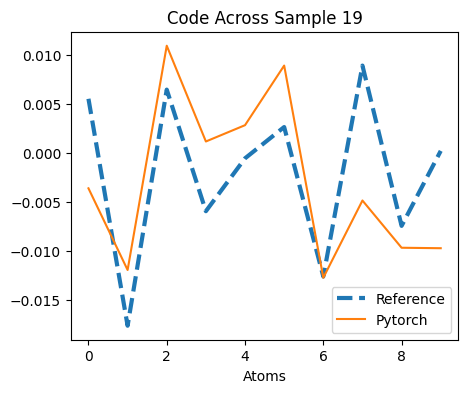

cost tensor([0.8074, 0.8978, 0.6248, 0.8090, 0.9767, 0.8648, 0.5041, 0.6465, 0.8059,
        0.7585])
median tensor(0.8059)
max tensor(0.9767)


<Figure size 640x480 with 0 Axes>

In [ ]:
(cost, median, max, indices ) = dictionary_distance( torch.tensor(input_code, dtype=torch.float32),torch.tensor(output_code, dtype=torch.float32),dictionary=False )
print("cost", cost)
print("median", median)
print("max", max)

In [ ]:
def dict_code_similarity_both(filepath1, guide_pool=False, conven=False):
                  # dictionary () , code (CELLS x ATOMS)
  plt.figure(figsize=(10,5))
  a = 9000
  b = 200


  if guide_pool:
    code_dict1 = np.load(os.path.join(filepath1,"code_guide_pooled_final_unrolled.npy"))
    code_dict2 = np.load('./data/SPAMS_output/SPAMS_code_KD_guide_pooled.npy')
  if conven:
    code_dict1 = np.load(os.path.join(filepath1,"code_conventional_final_unrolled.npy"))
    code_dict2 = np.load('./data/SPAMS_output/SPAMS_code_conventional.npy')

  # correct dimensions
  if code_dict1.shape[0] < code_dict1.shape[1]:
    code_dict1 = code_dict1.T
  if code_dict2.shape[0] < code_dict2.shape[1]:
    code_dict2 = code_dict2.T
  plt.plot(np.sum(np.abs(code_dict1[a:a+b, :]),axis=1), color="green", label='Pytorch code')
  plt.plot(np.sum(np.abs(code_dict2[a:a+b, :]),axis=1), color="black", label='SPAMS code')
  plt.title('Code Similarity')
  plt.legend()
  plt.show()
  plt.clf()

  if guide_pool:
    code_dict1 = np.load(os.path.join(filepath1,"dictionary_guide_pooled_final_unrolled.npy"))
    code_dict2 = np.load('./data/SPAMS_output/SPAMS_dictionary_KD_guide_pooled.npy')
  if conven:
    code_dict1 = np.load(os.path.join(filepath1,"dictionary_conventional_final_unrolled.npy"))
    code_dict2 = np.load('./data/SPAMS_output/SPAMS_dictionary_conventional.npy')

  # correct dimensions
  if code_dict1.shape[0] < code_dict1.shape[1]:
    code_dict1 = code_dict1.T
  if code_dict2.shape[0] < code_dict2.shape[1]:
    code_dict2 = code_dict2.T
  plt.plot(np.sum(np.abs(code_dict1[a:a+b, :]),axis=1), color="blue", label='Pytorch dict')
  plt.plot(np.sum(np.abs(code_dict2[a:a+b, :]),axis=1), color="red", label='SPAMS dict')
  plt.title('Dictionary Similarity')
  plt.show()
  plt.legend()
  plt.clf()



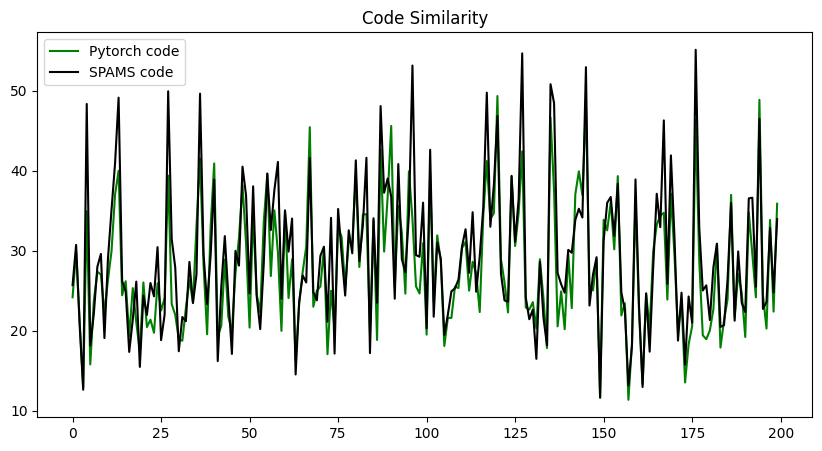

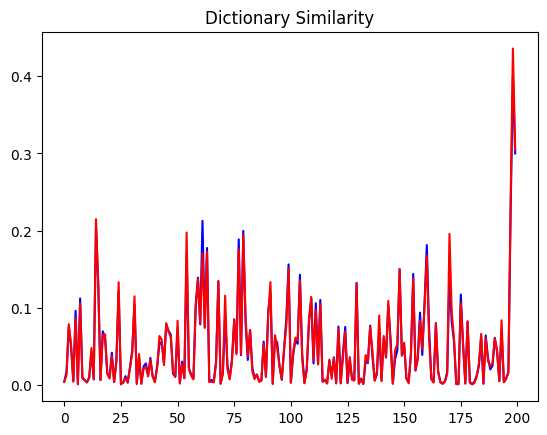

<Figure size 640x480 with 0 Axes>

In [ ]:
# filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_batch_2084_lambda_0.1_laplacian_False_epochs_500_2023_05_12_03_58_08/"
# dict_code_similarity_both(filepath1=filepath1, conven=True)

filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_batch_512_initial_dict_data_lambda_0.1_laplacian_False_epochs_200_2023_05_16_21_00_12/"
dict_code_similarity_both(filepath1=filepath1, guide_pool=True)